In [1]:
#from google.colab import drive

#drive.mount('/content/drive', force_remount=True)

LUNA_path = '/Volumes/Files_exFAT/LUNA16/'

In [2]:
# import os

# file_list = []

# for filename in os.listdir('drive/MyDrive/LUNA16/LUNA_Nilson/'):
#   if filename.endswith('.zip') and filename != "subset0.zip":
#     file_list.append(filename)
# print(file_list)

# for filename in file_list: 
#   # Eliminate errors
#   !zip -FF drive/MyDrive/LUNA16/LUNA_Nilson/{filename} --out drive/MyDrive/LUNA16/LUNA_Nilson/new_{filename}
#   !unzip drive/MyDrive/LUNA16/LUNA_Nilson/new_{filename} -d drive/MyDrive/LUNA16/LUNA_Nilson/


In [3]:
#!pip install SimpleITK

import os
import glob
import copy
import time

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from collections import namedtuple
import SimpleITK as sitk

#import torch
#from torch.utils.data import Dataset, DataLoader
#import torch.nn as nn
#import torch.optim as optim

In [4]:
df_annotations = pd.read_csv(LUNA_path + 'CSVFILES/annotations.csv')
df_annotations.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

In [5]:
print(f'Total annotations: {df_annotations.shape[0]}, Unique CT scans: {len(df_annotations.seriesuid.unique())}')

Total annotations: 1186, Unique CT scans: 601


In [6]:
# Create tuples to facilitate the handling
df_annotations['center_xyz'] = list(zip(df_annotations['coordX'], df_annotations['coordY'], df_annotations['coordZ']))

df_annotations = df_annotations[['seriesuid','center_xyz','diameter_mm']]
df_annotations.head()

seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   

                                   center_xyz  diameter_mm  
0  (-128.6994211, -175.3192718, -298.3875064)     5.651471  
1     (103.7836509, -211.9251487, -227.12125)     4.224708  
2    (69.63901724, -140.9445859, 876.3744957)     5.786348  
3    (-24.0138242, 192.1024053, -391.0812764)     8.143262  
4    (2.441546798, 172.4648812, -405.4937318)    18.545150

In [7]:
x,y,z = df_annotations.iloc[[0]]['center_xyz'][0]
x

-128.6994211

## Load the data

In [8]:
candidate = df_annotations.iloc[[0]]

candidate

seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   

                                   center_xyz  diameter_mm  
0  (-128.6994211, -175.3192718, -298.3875064)     5.651471

In [9]:
candidate.seriesuid[0]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860'

In [10]:
# Look for the file `<series_uid>.mhd` inside the `subset` folders
filepaths = glob.glob(f'{LUNA_path}/subset*/{candidate.seriesuid[0]}.mhd')

mhd_file_path = filepaths[0]

mhd_file_path

'/Volumes/Files_exFAT/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd'

In [11]:
mhd_file = sitk.ReadImage(mhd_file_path)

ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)

# Considering only densities between air (–1,000 HU) and below bones (at least +1,000 HU)
# tumors are around 0 HU
ct_scan.clip(-1000, 600, ct_scan)

#[–857.4 HU, –854.5 HU] Reference: Lung Cancer Detection and Classification with 3D Convolutional Neural Network (3D-CNN), 2017
#ct_scan.clip(-1000, -320, ct_scan)

array([[[-1000., -1000.,  -982., ...,  -950.,  -977., -1000.],
        [-1000., -1000.,  -997., ...,  -965.,  -978.,  -980.],
        [-1000., -1000., -1000., ...,  -966.,  -969.,  -973.],
        ...,
        [ -965.,  -953.,  -897., ...,  -415.,  -579.,  -736.],
        [-1000.,  -917.,  -860., ...,  -913.,  -968.,  -994.],
        [ -936.,  -840.,  -877., ..., -1000., -1000., -1000.]],

       [[ -992., -1000.,  -973., ...,  -975.,  -982.,  -996.],
        [ -985.,  -979.,  -972., ...,  -950.,  -993., -1000.],
        [-1000.,  -998.,  -969., ...,  -989., -1000., -1000.],
        ...,
        [ -895.,  -894.,  -875., ...,  -504.,  -621.,  -783.],
        [ -908.,  -865.,  -824., ...,  -967., -1000.,  -987.],
        [ -876.,  -814.,  -844., ..., -1000., -1000., -1000.]],

       [[ -972.,  -978.,  -988., ..., -1000., -1000., -1000.],
        [ -955.,  -964.,  -970., ...,  -989.,  -979.,  -978.],
        [ -962.,  -963.,  -954., ...,  -980.,  -989.,  -997.],
        ...,
        [ -9

In [12]:
ct_scan.shape

(194, 512, 512)

In [13]:
# Looking at the first slice
ct_scan[0].shape

(512, 512)

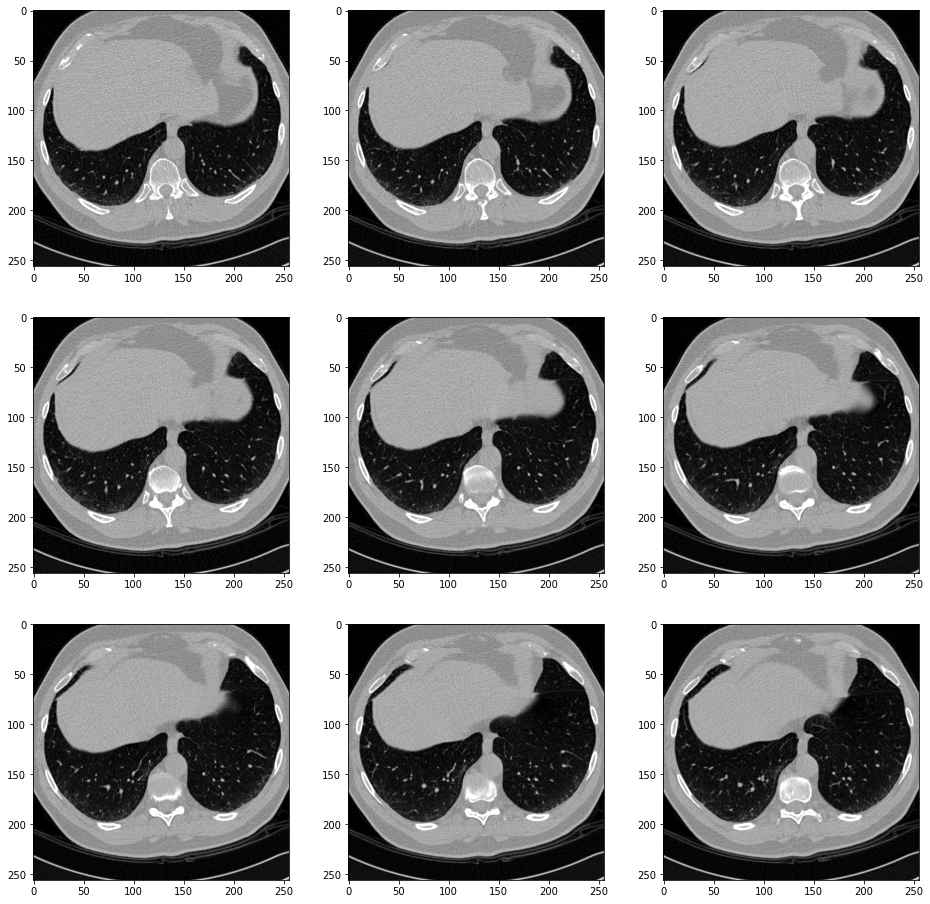

In [14]:
import matplotlib.pyplot as plt
import cv2

width = 256
height = 256


fig = plt.figure(figsize=(16,16))

for i, slices in enumerate(range(60,69)):
  #print(slices)
  ct_scan_resized = cv2.resize(ct_scan[slices], (width,height))
  
  subplot = fig.add_subplot(3,3,i+1)
  subplot.imshow(ct_scan_resized, cmap='gray')

plt.show()

In [15]:
origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

In [16]:
def xyz2irc(coord_xyz, origin_xyz, vx_size_xyz, direction_matrix):
  #We convert the origin and voxel size to NumPy arrays so that they are easier to use in calculations.
  coord_np = np.array(coord_xyz)
  origin_np = np.array(origin_xyz)
  vx_size_np = np.array(vx_size_xyz)

  # Convert the coordinates of the center of the candidate
  # from the patient millimeter coordinate system (X,Y,Z) to voxel-address-based (I,R,C)
  cri = ((coord_np - origin_np) @ np.linalg.inv(direction_matrix)) / vx_size_np
  # Since we'll be using column, row and index values to index into arrays,
  # we round them to the nearest integer.
  cri = np.round(cri)

  # Going forward, we'll need the scan to be in the order index, row, column
  return (int(cri[2]), int(cri[1]), int(cri[0]))

In [17]:
# Testing for origin coordinates
print(xyz2irc(mhd_file.GetOrigin(), origin_xyz, voxel_size_xyz, direction_matrix))

(0, 0, 0)


In [18]:
# Find the nodule position in the image (i,r,c)
print(xyz2irc(candidate['center_xyz'][0], origin_xyz, voxel_size_xyz, direction_matrix))

(78, 212, 45)


In [19]:
# Get the nodule radius in pixels
def get_radius_px(diammeter_mm, voxel_size_xyz):

  diammeter_px = diammeter_mm / voxel_size_xyz[0]

  return int(diammeter_px/2)+1

In [20]:
# AP^small: AP for small objects: area < 32² px
# AP^medium: AP for medium objects: 32² < area < 96² px
# AP^large: AP for large objects: area > 96² px

AP_small = 0
AP_medium = 0
AP_large = 0

for index, candidate in df_annotations.iterrows():
  nod_diam_px = get_radius_px(candidate['diameter_mm'], voxel_size_xyz)*2
  if nod_diam_px <= 32:
    AP_small += 1
  elif (nod_diam_px > 32 and nod_diam_px <96):
    AP_medium += 1
  else:
    AP_large += 1

print(AP_small, AP_medium, AP_large)

# for index, candidate in df_annotations.iterrows():
#   print(f"diameter_mm = { candidate['diameter_mm'] }")
#   nod_radius = get_radius_px(candidate['diameter_mm'], voxel_size_xyz)
#   print(f"diameter_px = {2*nod_radius}\n")

1143 43 0


In [21]:
len(df_annotations['seriesuid'].unique())

601

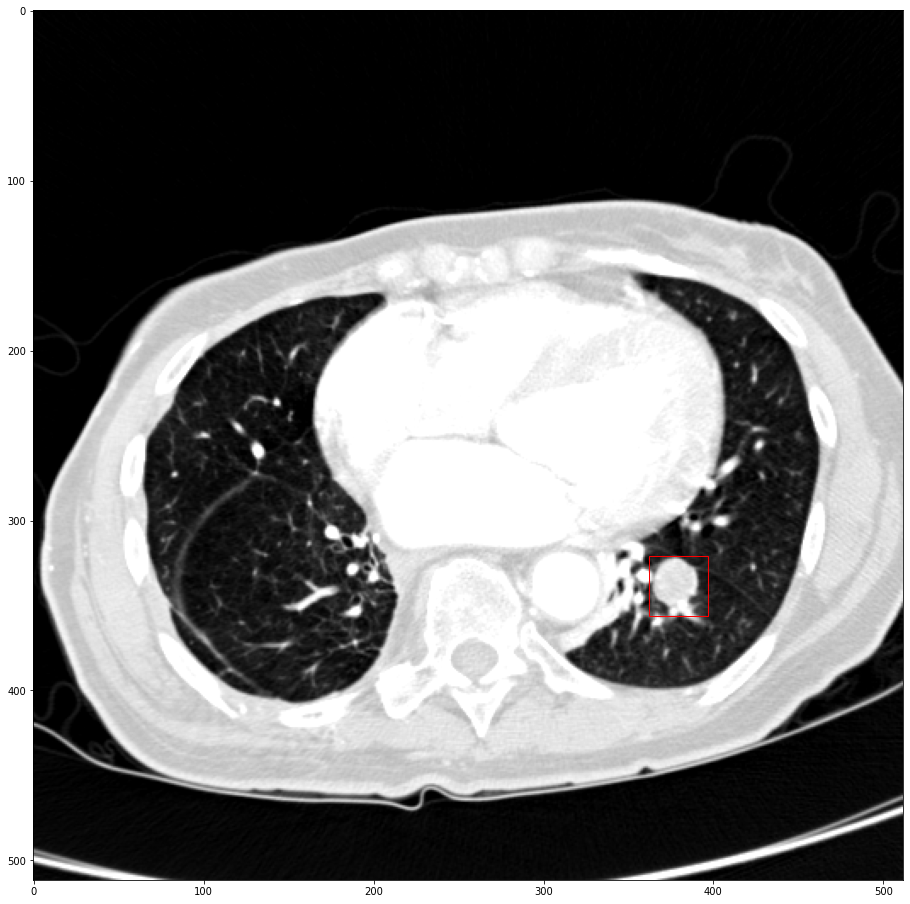

In [61]:
# Show the nodule in the image
import matplotlib.patches as patches

candidate = df_annotations.iloc[[6]] #5

filepaths = glob.glob(f'{LUNA_path}/subset*/{list(candidate.seriesuid)[0]}.mhd')
mhd_file_path = filepaths[0]
mhd_file = sitk.ReadImage(mhd_file_path)
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)

#[–857.4 HU, –854.5 HU] Reference: Lung Cancer Detection and Classification with 3D Convolutional Neural Network (3D-CNN), 2017
#ct_scan.clip(-1000, -320, ct_scan)
#
ct_scan.clip(-1000, 200, ct_scan)


origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)



ind, row, col  = xyz2irc(list(candidate['center_xyz'])[0], origin_xyz, voxel_size_xyz, direction_matrix)
nod_radius = get_radius_px(candidate['diameter_mm'], voxel_size_xyz)
box_w = box_h = nod_radius*2 + 5


# Create figure and axes
fig, ax = plt.subplots(figsize=(16,16))

# Display the image
ax.imshow(ct_scan[ind], cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((col - nod_radius, row - nod_radius), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [23]:
# Get all the nodules from the same CT scan (same series_uid) and convert the positions from xyz to irc
def get_nodules_list_irc(series_uid):
  df = df_annotations[ df_annotations['seriesuid'] == series_uid ]

  # Get DICOM info
  filepaths = glob.glob(f'{LUNA_path}/subset*/{series_uid}.mhd')
  mhd_file_path = filepaths[0]
  mhd_file = sitk.ReadImage(mhd_file_path)

  origin_xyz = mhd_file.GetOrigin()
  vx_size_xyz = mhd_file.GetSpacing()
  direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)


  NoduleTuple = namedtuple('NoduleTuple', ['center_irc','radius_px'])

  # A list to store all the nodules in the CT scan
  nodules_list = []
  
  for index, row in df.iterrows():
    nod_center_irc = xyz2irc(row['center_xyz'], origin_xyz, vx_size_xyz, direction_matrix)
    #print(row['center_xyz'])
    nod_radius = get_radius_px(row['diameter_mm'], vx_size_xyz)
    
    nodules_list.append( NoduleTuple(nod_center_irc,nod_radius) )    

  return nodules_list

In [24]:
seriesuid = df_annotations.iloc[3]['seriesuid']
#seriesuid
temp_nod_list = get_nodules_list_irc(seriesuid)
temp_nod_list

[NoduleTuple(center_irc=(266, 328, 173), radius_px=8),
 NoduleTuple(center_irc=(252, 293, 220), radius_px=17),
 NoduleTuple(center_irc=(230, 251, 379), radius_px=17),
 NoduleTuple(center_irc=(142, 336, 377), radius_px=15)]

## Creating a class to generalise the ct_scan properties

Now we create an object for every CT scan in the dataset because they share the same properties (origin, spacing, direction matrix, etc).

In [25]:
class Ct:

  # default constructor
  def __init__(self, series_uid):

    self.series_uid = series_uid
    self.mhd_path = glob.glob(f'{LUNA_path}/subset*/{series_uid}.mhd')[0]
    
    mhd_file = sitk.ReadImage(self.mhd_path)  # Temporary variable
    self.vx_size_xyz = mhd_file.GetSpacing()
    
    self.annotations = get_nodules_list_irc(self.series_uid)

  # [–1000 HU, –320 HU] Reference: Lung Cancer Detection and Classification with 3D Convolutional Neural Network (3D-CNN), 2017
  def get_mhd(self, hu_min=-1000, hu_max=-320):
    mhd_file = sitk.ReadImage(self.mhd_path)
    ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)

    return ct_scan.clip(hu_min, hu_max, ct_scan)
    #return ct_scan.clip(-1000, 200, ct_scan)

In [26]:
# Example using a single UID
# Show all the nodules in the first Ct scan
ct_scan_1 = Ct(df_annotations.iloc[3]['seriesuid'])

# Nodules in ct_scan
ct_scan_1.annotations

[NoduleTuple(center_irc=(266, 328, 173), radius_px=8),
 NoduleTuple(center_irc=(252, 293, 220), radius_px=17),
 NoduleTuple(center_irc=(230, 251, 379), radius_px=17),
 NoduleTuple(center_irc=(142, 336, 377), radius_px=15)]

Create an object for every Ct scan in the dataset

In [27]:
# unique_series_uid = df_annotations['seriesuid'].unique()
# ct_scan_list = []

# for uid in tqdm(unique_series_uid):
#  ct_scan_list.append( Ct(uid) )

In [28]:
import dill

# Save the file
#dill.dump(ct_scan_list, file = open(LUNA_path + "ct_scan_list.pickle", "wb"))

# Reload the file
ct_scan_list = dill.load(open(LUNA_path + "ct_scan_list.pickle", "rb"))

In [29]:
len(ct_scan_list)

601

In [30]:
# Calculate total number of slices
# total_slices = 0

# for ct_scan_i in ct_scan_list:
#     total_slices += ct_scan_i.get_mhd().shape[0]

# print(total_slices)

(110, 270, 449) 5
(81, 264, 414) 5
(96, 450, 170) 4
(114, 427, 133) 8
(117, 317, 69) 7
(126, 424, 383) 6


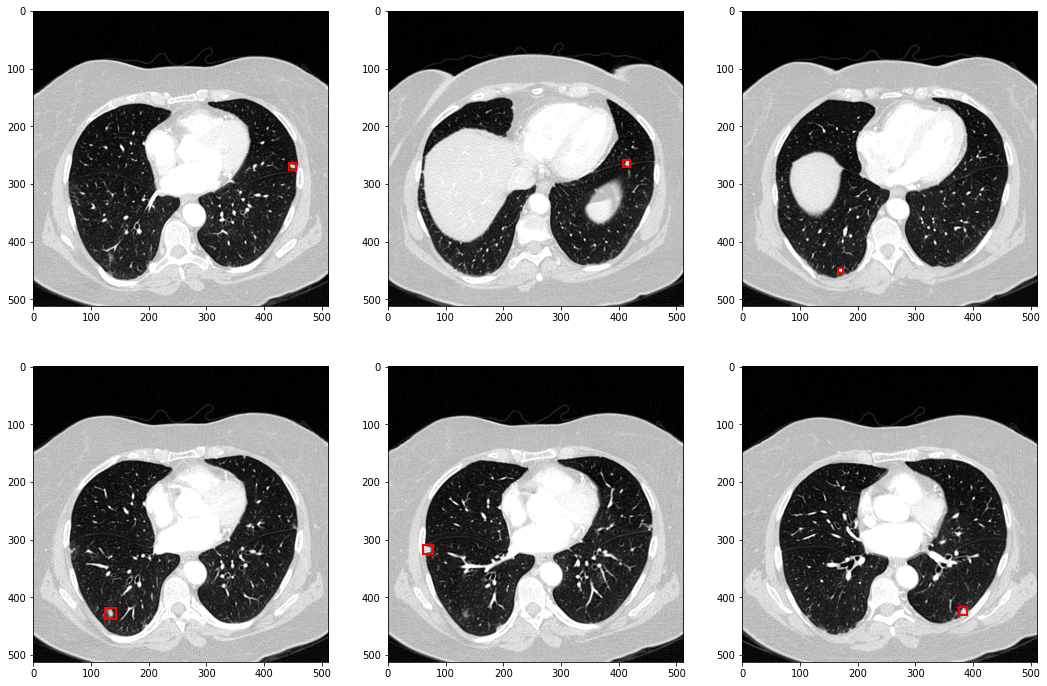

In [31]:
# Let's plot all the nodules in the given Ct scan

ct_scan_i = ct_scan_list[12]

# Create figure and axes
fig, ax = plt.subplots(2,3, figsize=(18,12))
ax = ax.flatten()

for i, nod in enumerate(ct_scan_i.annotations):

  slice_, row, col = nod.center_irc
  print(nod.center_irc, nod.radius_px)
  box_w = box_h = (nod.radius_px * 2) * 1.2 # Box has 120% of the diameter size

  # Display the image
  #ax.imshow(ct_scan_i.get_mhd()[slice_], cmap='gray')
  ax[i].imshow(ct_scan_i.get_mhd(-1000,200)[slice_], cmap='gray')

  # Create a Rectangle patch (column = x, row = y)
  rect = patches.Rectangle((col - box_w/2, row - box_h/2), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax[i].add_patch(rect)

plt.show()

In [32]:
ct_scan_i.vx_size_xyz

(0.60546875, 0.60546875, 1.0)

In [33]:
# Generate a list of slices to plot including the the previous and the next slices from the nodule
def generate_slices(annotations_list):
  slices_dict = {}
  for nodule in annotations_list:
    idx = nodule.center_irc[0]  # Get the indexes of all nodules

    # Add center slice
    if idx in slices_dict:
      slices_dict[idx].append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
    else:
      slices_dict.setdefault(idx, []).append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
   
    # Add previous slice
    if idx-1 in slices_dict:
      slices_dict[idx-1].append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
    else:
      slices_dict.setdefault(idx-1, []).append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))

    # Add subsequent slice
    if idx+1 in slices_dict:
      slices_dict[idx+1].append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
    else:
      slices_dict.setdefault(idx+1, []).append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))

  return slices_dict


ct_scan_i = ct_scan_list[43]  # 21, 43
slices_dict = generate_slices(ct_scan_i.annotations)  # talvez ter que passar o Ct_scan.shape para não ultrapassar o limite
slices_dict

{89: [(356, 155, 6)],
 88: [(356, 155, 6)],
 90: [(356, 155, 6)],
 113: [(315, 348, 9), (356, 185, 4)],
 112: [(315, 348, 9), (356, 185, 4)],
 114: [(315, 348, 9), (356, 185, 4)]}

In [34]:
# Generate a list of slices to plot based on the nodule center and diameter
# Larger nodules will have more slices included
def generate_slices(annotations_list, vx_size_xyz):
  slices_dict = {}
  for nodule in annotations_list:
    idx = nodule.center_irc[0]  # Get the indexes of all nodules

    # Add center slice
    if idx in slices_dict:
      slices_dict[idx].append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
    else:
      slices_dict.setdefault(idx, []).append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
   
    # Calculate how far the nodule goes in the Z axis (half the pixels in the other axis)
    axial_spacing = vx_size_xyz[0]/vx_size_xyz[2]
    depth = nodule.radius_px * axial_spacing
    #print("Depth: ", depth)

    # Keep only the slices up to half the radius
    half_depth = int(depth/2)
    for i in range(1,half_depth+1):
      #print(i)
      # Add previous slice
      if idx-i in slices_dict:
        slices_dict[idx-i].append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
      else:
        slices_dict.setdefault(idx-i, []).append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))

      # Add subsequent slice
      if idx+i in slices_dict:
        slices_dict[idx+i].append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))
      else:
        slices_dict.setdefault(idx+i, []).append((nodule.center_irc[1],nodule.center_irc[2],nodule.radius_px))

  return slices_dict


ct_scan_i = ct_scan_list[21]  # 21, 43, 110
slices_dict = generate_slices(ct_scan_i.annotations, ct_scan_i.vx_size_xyz)
slices_dict

{88: [(321, 181, 4)],
 82: [(233, 130, 4)],
 91: [(328, 320, 5)],
 64: [(228, 90, 3)],
 57: [(305, 231, 4)],
 90: [(270, 357, 4)],
 86: [(309, 342, 3)],
 69: [(287, 393, 6)]}

In [35]:
for index in slices_dict:
  for nod in slices_dict[index]: 
    print(index,nod)

88 (321, 181, 4)
82 (233, 130, 4)
91 (328, 320, 5)
64 (228, 90, 3)
57 (305, 231, 4)
90 (270, 357, 4)
86 (309, 342, 3)
69 (287, 393, 6)


104 259 118 7


/Users/nilson/miniconda3/envs/preprocess-LUNA16/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


103 259 118 7
105 259 118 7
102 259 118 7
106 259 118 7


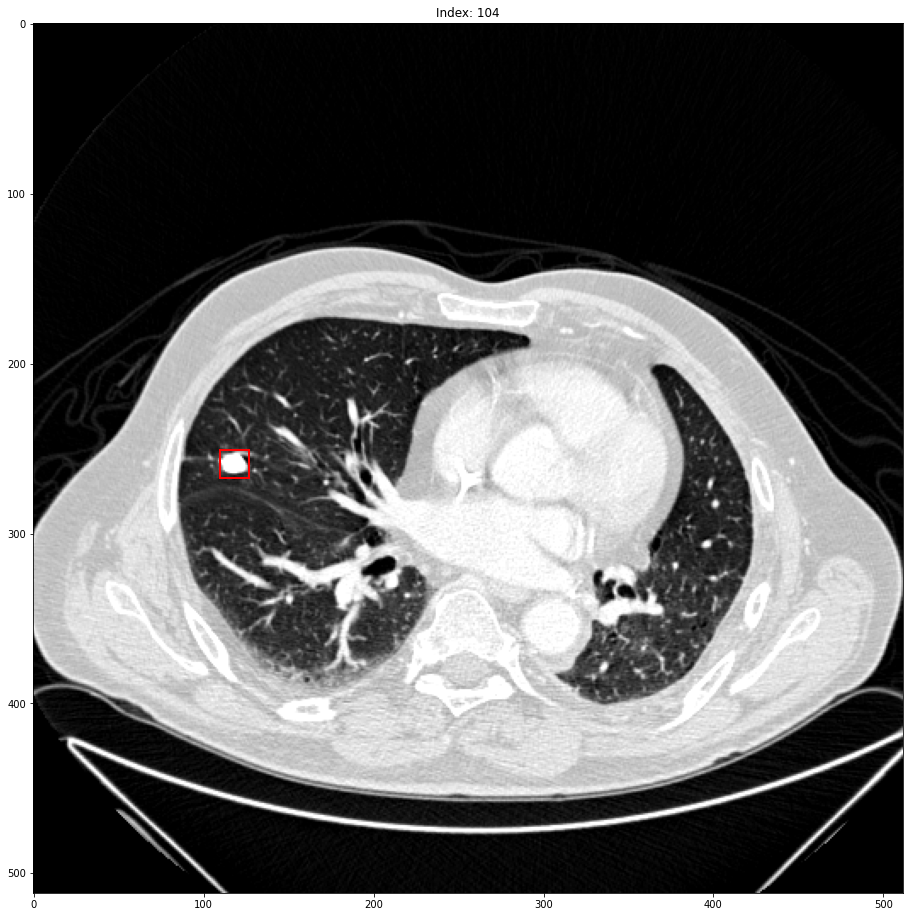

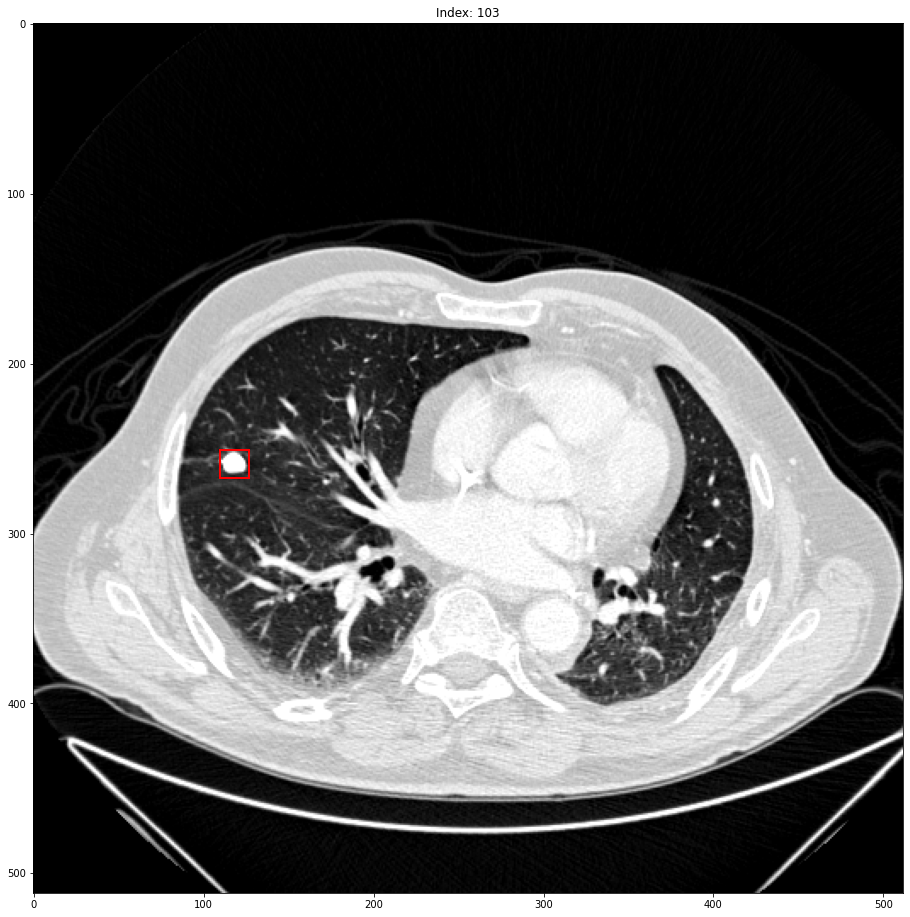

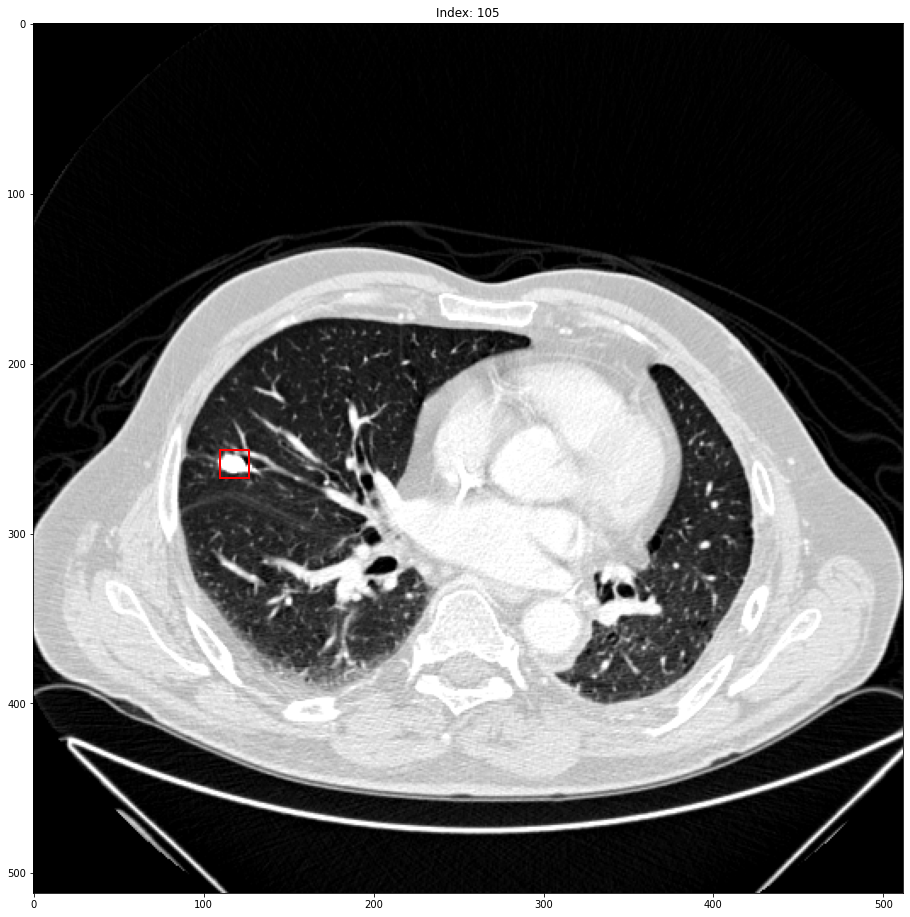

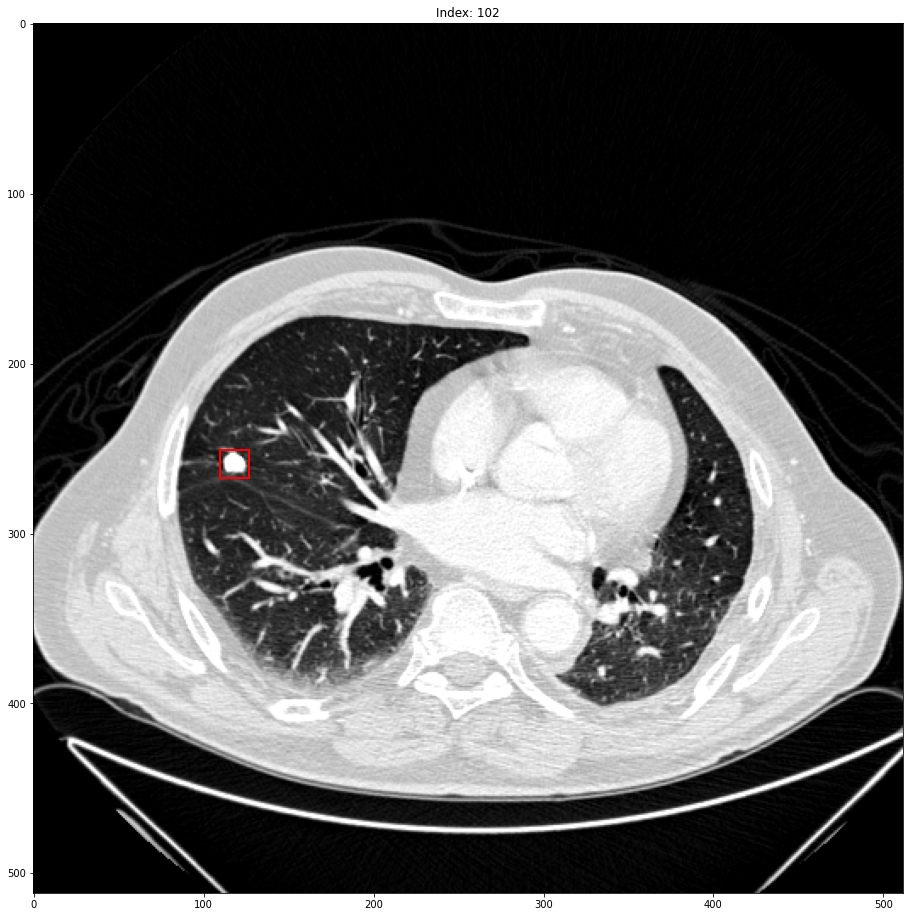

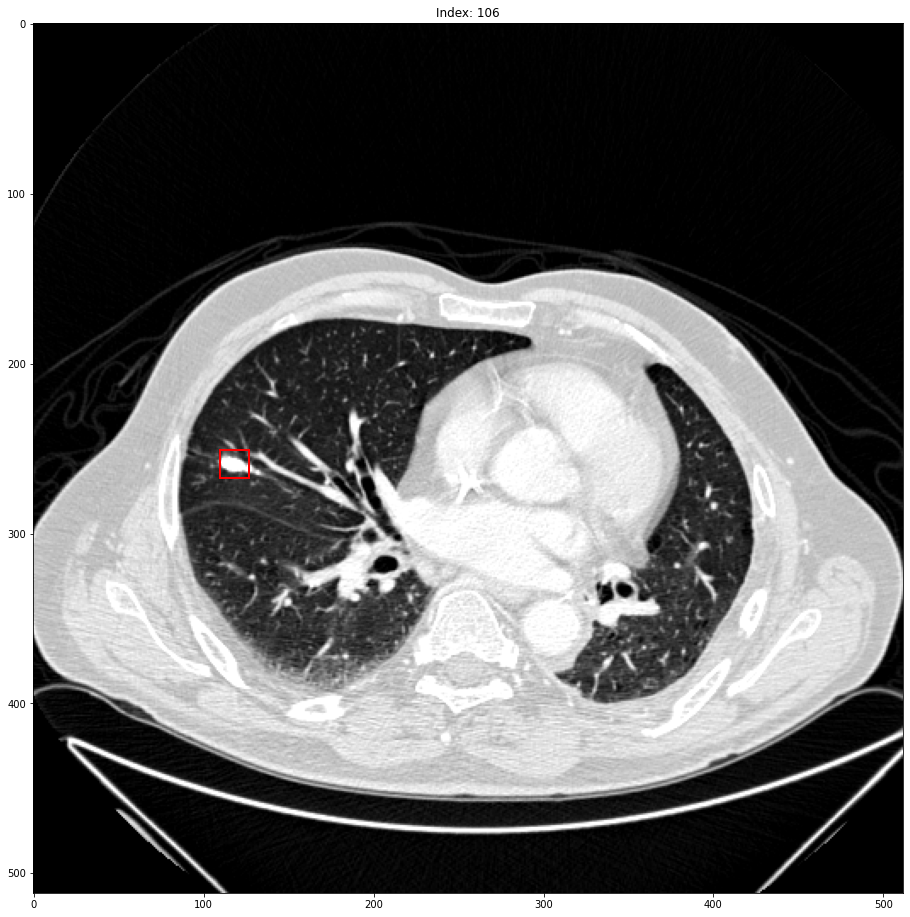

In [48]:
# Let's plot all the nodules in the given Ct scan

ct_scan_i = ct_scan_list[5] #12
slices_dict = generate_slices(ct_scan_i.annotations, ct_scan_i.vx_size_xyz)

for index in slices_dict:
  # Create figure and axes
  fig, ax = plt.subplots(figsize=(16,16))
  
  for nod in slices_dict[index]:
    row, col, radius = nod[0], nod[1], nod[2]
    print(index, row, col, radius)
    box_w = box_h = (radius * 2) * 1.2 # Box has 120% of the diameter size

    # Display the image
    ax.imshow(ct_scan_i.get_mhd(-1000,200)[index], cmap='gray')

    # Create a Rectangle patch (column = x, row = y)
    rect = patches.Rectangle((col - box_w/2, row - box_h/2), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.set_title('Index: '+str(index))

  fig.show()

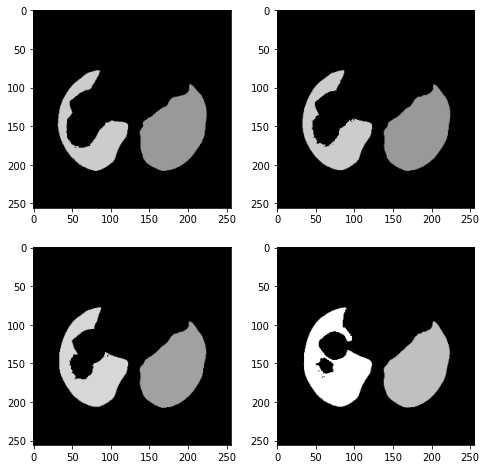

In [37]:
seg_mhd_path = glob.glob(f'{LUNA_path}/seg-lungs-LUNA16/{ct_scan_list[43].series_uid}.mhd')[0]

seg_mhd_file = sitk.ReadImage(seg_mhd_path)
seg_ct_scan = np.array(sitk.GetArrayFromImage(seg_mhd_file), dtype=np.float32)

#seg_ct_scan.clip(-1000, -320, seg_ct_scan)

seg_ct_scan.shape

width = 256
height = 256

fig = plt.figure(figsize=(8,8))

for i, slices in enumerate(range(60,64)):
  #print(slices)
  ct_scan_resized = cv2.resize(seg_ct_scan[slices], (width,height))
  
  subplot = fig.add_subplot(2,2,i+1)
  subplot.imshow(ct_scan_resized, cmap='gray')

plt.show()

In [38]:
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts
from scipy import ndimage as ndi

# Source: https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing/notebook
def get_lung_roi(im, plot=False):
    if plot == True:
        fig = plt.figure(figsize=(16,8))

    # Step 1: Convert into a binary image. 
    binary = im < -400
    if plot == True:
        #plt.imshow(binary, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,1)
        subplot.imshow(binary, cmap='gray')

    # Step 2: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary)
    if plot == True:
        #plt.imshow(cleared, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,2)
        subplot.imshow(cleared, cmap='gray')

    # Step 3: Label the image.
    label_image = label(cleared)
    if plot == True:
        #plt.imshow(cleared, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,3)
        subplot.imshow(cleared, cmap='gray')

    # Step 4: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                        label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        #plt.imshow(binary, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,4)
        subplot.imshow(binary, cmap='gray')

    # Step 5: Erosion operation with a disk of radius 2. This operation is 
    # to seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        #plt.imshow(binary, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,5)
        subplot.imshow(binary, cmap='gray')

    # Step 6: Closure operation with a disk of radius 10. This operation is 
    # to keep nodules attached to the lung wall.
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        #plt.imshow(binary, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,6)
        subplot.imshow(binary, cmap='gray')

    # Step 7: Fill in the small holes inside the binary mask of lungs.
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        #plt.imshow(binary, cmap=plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,7)
        subplot.imshow(binary, cmap='gray')

    # Step 8: Superimpose the binary mask on the input image.
    get_high_vals = binary == 0
    im += 1000
    im[get_high_vals] = 0
    if plot == True:
        #plt.imshow(im, cmap='gray') #plt.cm.bone)
        #plt.show()
        subplot = fig.add_subplot(2,4,8)
        subplot.imshow(im, cmap='gray')

    return im

In [39]:
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts
from scipy import ndimage as ndi

# Source: https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing/notebook
def get_lung_roi(im, plot=False):
  # Step 1: Convert into a binary image. 
  binary = im < -400
  if plot == True:
      plt.imshow(binary, cmap=plt.cm.bone)
      plt.show()

  # Step 2: Remove the blobs connected to the border of the image.
  cleared = clear_border(binary)
  if plot == True:
      plt.imshow(cleared, cmap=plt.cm.bone)
      plt.show()

  # Step 3: Label the image.
  label_image = label(cleared)
  if plot == True:
      plt.imshow(cleared, cmap=plt.cm.bone)
      plt.show()

  # Step 4: Keep the labels with 2 largest areas.
  areas = [r.area for r in regionprops(label_image)]
  areas.sort()
  if len(areas) > 2:
      for region in regionprops(label_image):
          if region.area < areas[-2]:
              for coordinates in region.coords:                
                      label_image[coordinates[0], coordinates[1]] = 0
  binary = label_image > 0
  if plot == True:
      plt.imshow(binary, cmap=plt.cm.bone)
      plt.show()

  # Step 5: Erosion operation with a disk of radius 2. This operation is 
  # to seperate the lung nodules attached to the blood vessels.
  selem = disk(2)
  binary = binary_erosion(binary, selem)
  if plot == True:
      plt.imshow(binary, cmap=plt.cm.bone)
      plt.show()

  # Step 6: Closure operation with a disk of radius 10. This operation is 
  # to keep nodules attached to the lung wall.
  selem = disk(10)
  binary = binary_closing(binary, selem)
  if plot == True:
      plt.imshow(binary, cmap=plt.cm.bone)
      plt.show()

  # Step 7: Fill in the small holes inside the binary mask of lungs.
  edges = roberts(binary)
  binary = ndi.binary_fill_holes(edges)
  if plot == True:
      plt.imshow(binary, cmap=plt.cm.bone)
      plt.show()

  # Step 8: Superimpose the binary mask on the input image.
  get_high_vals = binary == 0
  im += 1000
  im[get_high_vals] = 0
  if plot == True:
      plt.imshow(im, cmap='gray') #plt.cm.bone)
      plt.show()

  return im

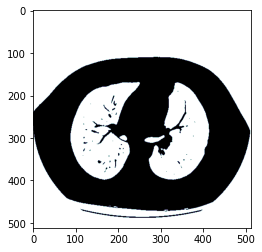

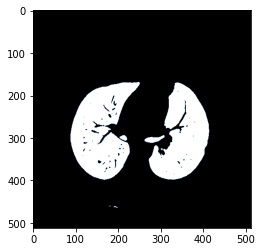

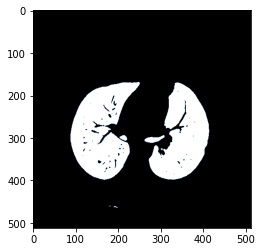

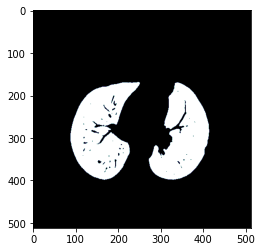

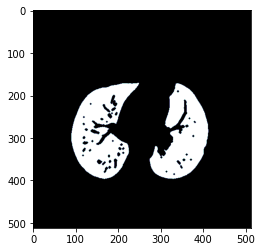

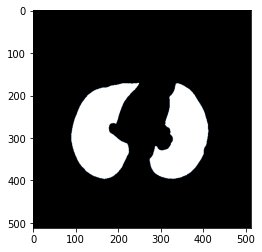

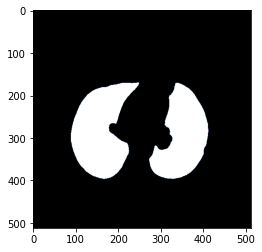

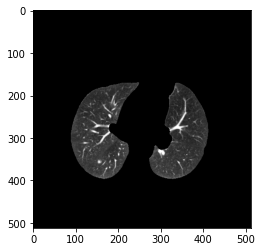

In [40]:
ct_scan_i = ct_scan_list[43]
img = ct_scan_i.get_mhd(-1000,0)[88]

img_roi = get_lung_roi(img, plot=True)

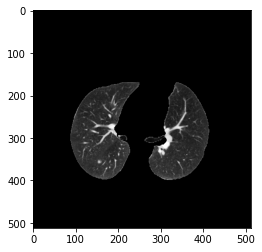

In [41]:
#filter image using LUNA segmentation
nod_index = 43
ct_scan_i = ct_scan_list[nod_index]
img = ct_scan_i.get_mhd(-1000,200)[88]


seg_mhd_path = glob.glob(f'{LUNA_path}/seg-lungs-LUNA16/{ct_scan_list[nod_index].series_uid}.mhd')[0]
seg_mhd_file = sitk.ReadImage(seg_mhd_path)
seg_mask = np.array(sitk.GetArrayFromImage(seg_mhd_file), dtype=np.float32)

# shift the image from [-1000,320] to [0,1320] scale, so that 0 annules the regions outside the lungs
img += 1000
seg_mask[ seg_mask > 0 ] = 1

plt.imshow(img*seg_mask[88], cmap='gray')

In [42]:
#ct_scan_i.get_mhd

#!cp 'drive/MyDrive/LUNA16/LUNA_Nilson/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.raw' 'drive/MyDrive/LUNA16/LUNA_Nilson'

In [43]:
def get_seg_mask(series_uid):
  seg_mhd_path = glob.glob(f'{LUNA_path}/seg-lungs-LUNA16/{series_uid}.mhd')[0]
  seg_mhd_file = sitk.ReadImage(seg_mhd_path)
  seg_mask = np.array(sitk.GetArrayFromImage(seg_mhd_file), dtype=np.float32)
  return seg_mask

89 356 155 6


/Users/nilson/miniconda3/envs/preprocess-LUNA16/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


88 356 155 6
90 356 155 6
113 315 348 9
113 356 185 4
112 315 348 9
114 315 348 9


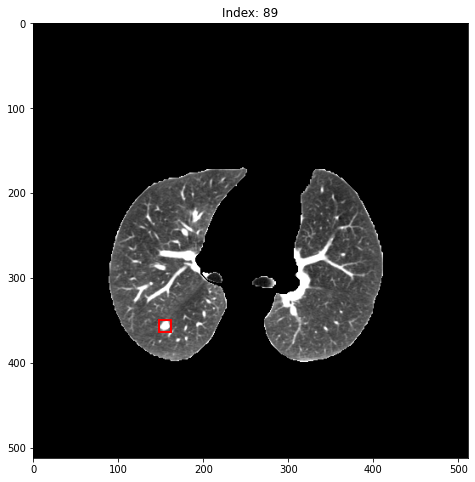

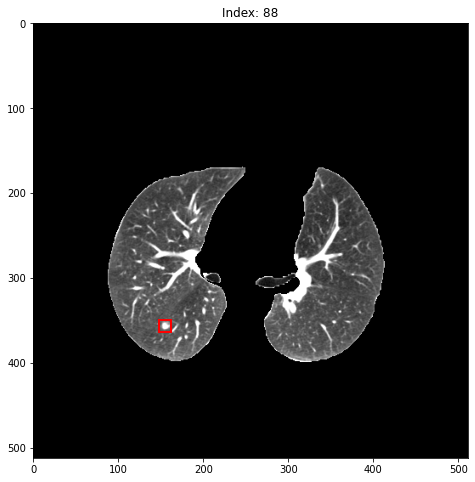

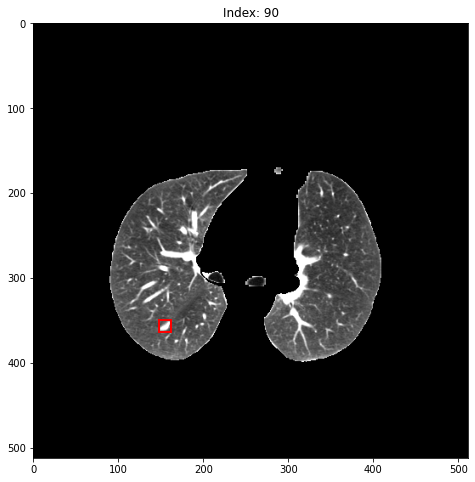

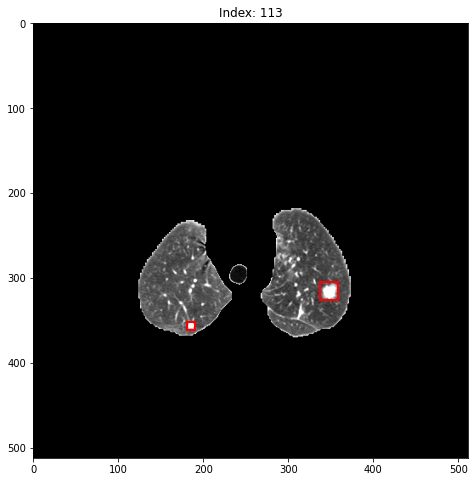

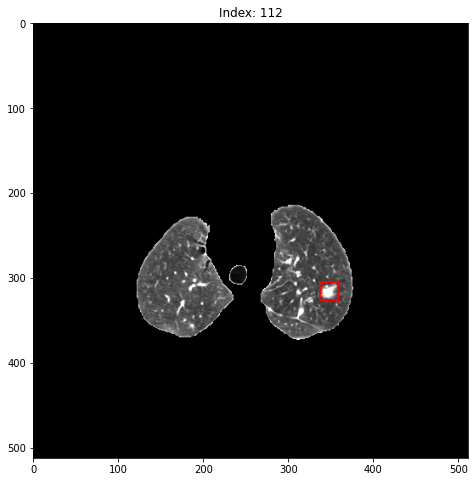

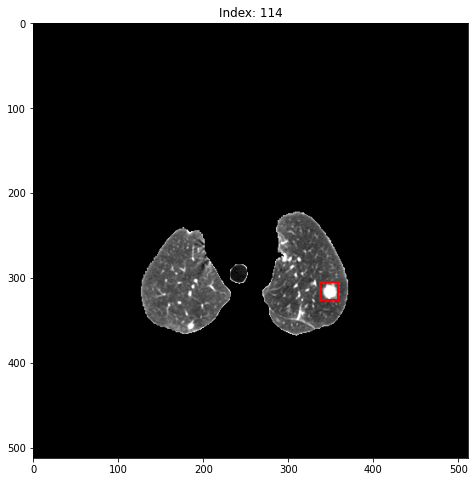

In [44]:
# Let's plot all the nodules in the given Ct scan

nod_index = 43
ct_scan_i = ct_scan_list[nod_index]
slices_dict = generate_slices(ct_scan_i.annotations, ct_scan_i.vx_size_xyz)

for index in slices_dict:
  # Create figure and axes
  fig, ax = plt.subplots(figsize=(8,8))
  
  seg_mask = get_seg_mask(ct_scan_i.series_uid)

  # shift the image from [-1000,320] to [0,1320] scale, so that 0 annules the regions outside the lungs
  img = ct_scan_i.get_mhd()[index]
  img += 1000
  seg_mask[ seg_mask > 0 ] = 1

  # Display the image
  ax.imshow(img * seg_mask[index], cmap='gray') #cmap=plt.cm.bone

  # Display the nodules
  for nod in slices_dict[index]:
    row, col, radius = nod[0], nod[1], nod[2]
    print(index, row, col, radius)
    box_w = box_h = (radius * 2) * 1.2 # Box has 120% of the diameter size

    # Create a Rectangle patch (column = x, row = y)
    rect = patches.Rectangle((col - box_w/2, row - box_h/2), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.set_title('Index: '+str(index))

  fig.show()

In [45]:
# Test to save the YOLO file
import os

nod_index = 43
ct_scan_i = ct_scan_list[nod_index]
slices_dict = generate_slices(ct_scan_i.annotations, ct_scan_i.vx_size_xyz)


os.makedirs(LUNA_path+'test_dataset', exist_ok=False)
print("Folder created!")


for index in slices_dict:
  # Create figure and axes
  #fig, ax = plt.subplots(figsize=(8,8))
  
  img = get_lung_roi(ct_scan_i.get_mhd(-1000,200)[index])

  # Get the CT image
  #plt.imshow(img, cmap='gray')

  # Save image
  #plt.axis('off')
  #plt.savefig(f'drive/MyDrive/LUNA16/LUNA_Nilson/test_dataset/img_{ct_scan_i.series_uid}_{index}.jpg', dpi=my_dpi*2, bbox_inches='tight',pad_inches = 0)
  plt.imsave(fname=f'{LUNA_path}/test_dataset/img_{ct_scan_i.series_uid}_{index}.jpg', arr=img, cmap='gray', format='jpg')
  #plt.close('all')

  # Get and save the nodules positions
  for nod in slices_dict[index]:
    row, col, radius = nod[0], nod[1], nod[2]
    print(index, row, col, radius)
    box_w = box_h = (radius * 2) * 1.2 # Box has 120% of the diameter size

    # Create a Rectangle patch (column = x, row = y)
    #rect = patches.Rectangle((col - box_w/2, row - box_h/2), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')

    # Convert to YOLO's relative coordinates
    h_img = img.shape[0]
    w_img = img.shape[1]

    x_center = col / w_img
    y_center = row / h_img
    w = box_w / w_img
    h = box_h / h_img

    # Write the labels to the txt YOLO file
    # Open the file in append & read mode ('a+')
    with open(f'{LUNA_path}/test_dataset/img_{ct_scan_i.series_uid}_{index}.txt', "a+") as file_object:
      # Move read cursor to the start of file.
      file_object.seek(0)
      # If file is not empty then append '\n'
      data = file_object.read(100)
      if len(data) > 0 :
          file_object.write("\n")
      # Append text at the end of file
      file_object.write(f'0 {x_center} {y_center} {w} {h}')

FileExistsError: [Errno 17] File exists: '/Volumes/Files_exFAT/LUNA16/test_dataset'

In [ ]:
## Function to save images and the coordinates in the YOLO format
# Use imsave instead of savefig: https://stackoverflow.com/a/63091765
# https://stackoverflow.com/questions/31544130/saving-an-imshow-like-image-while-preserving-resolution

def save_dataset_yolo(ct_scan_list, segmented=False, folder='dataset'):
  # Create the folder
  os.makedirs(LUNA_path + folder, exist_ok=False)
  print("Folder created!")

  for ct_scan_i in tqdm(ct_scan_list):
    slices_dict = generate_slices(ct_scan_i.annotations, ct_scan_i.vx_size_xyz)
    #print(f'Series UID: {ct_scan_i.series_uid}')
    #print(f'{n+1}/{len(ct_scan_list)}')

    for index in slices_dict:
      if segmented: 
        img = get_lung_roi(ct_scan_i.get_mhd(-1000,200)[index])
      else:
        img = ct_scan_i.get_mhd(-1000,200)[index]

      # Print the CT image
      #plt.imshow(img, cmap='gray')

      # Save image
      #plt.axis('off')
      #plt.savefig(f'drive/MyDrive/LUNA16/LUNA_Nilson/{folder}/img_{ct_scan_i.series_uid}_{index}.jpg', bbox_inches='tight',pad_inches = 0)
      plt.imsave(fname=f'{LUNA_path}/{folder}/img_{ct_scan_i.series_uid}_{index}.jpg', arr=img, cmap='gray', format='jpg')
      
      #plt.clf()
      #plt.close('all')

      # Get and save the nodules positions
      for nod in slices_dict[index]:
        row, col, radius = nod[0], nod[1], nod[2]
        #print(index, row, col, radius)
        box_w = box_h = (radius * 2) * 1.2 # Box has 120% of the diameter size

        # Create a Rectangle patch (column = x, row = y)
        #rect = patches.Rectangle((col - box_w/2, row - box_h/2), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')

        # Convert to YOLO's relative coordinates
        h_img = img.shape[0]
        w_img = img.shape[1]

        x_center = col / w_img
        y_center = row / h_img
        w = box_w / w_img
        h = box_h / h_img

        # Write the labels to the txt YOLO file
        # Open the file in append & read mode ('a+')
        with open(f'{LUNA_path}/{folder}/img_{ct_scan_i.series_uid}_{index}.txt', "a+") as file_object:
          # Move read cursor to the start of file.
          file_object.seek(0)
          # If file is not empty then append '\n'
          data = file_object.read(100)
          if len(data) > 0 :
              file_object.write("\n")
          # Append text at the end of file
          file_object.write(f'0 {x_center} {y_center} {w} {h}')

    #del img  # delete the image to avoid memory leak

In [ ]:
#save_dataset_yolo(ct_scan_list, segmented=True, folder='dataset_segmented')
#save_dataset_yolo(ct_scan_list, segmented=False, folder='dataset')

In [ ]:
# Train/validation split

test_ct_scan_list = ct_scan_list[:119]  # 20% for validation/test
train_ct_scan_list = ct_scan_list[120:]  # 80% for train

In [ ]:
total_imgs_test = []
total_imgs_train = []

for ct in test_ct_scan_list:
    slices_dict = generate_slices(ct.annotations, ct.vx_size_xyz)

    total_imgs_test.extend(slices_dict)

for ct in train_ct_scan_list:
    slices_dict = generate_slices(ct.annotations, ct.vx_size_xyz)

    total_imgs_train.extend(slices_dict)

print(f'Total images in test: {len(total_imgs_test)}')
print(f'Total images in train: {len(total_imgs_train)}')

Total images in test: 832
Total images in train: 3255


In [ ]:
#save_dataset_yolo(test_ct_scan_list, segmented=True, folder='dataset2_seg_test')
#save_dataset_yolo(train_ct_scan_list, segmented=True, folder='dataset2_seg_train')

#save_dataset_yolo(test_ct_scan_list, segmented=False, folder='dataset2_test')
#save_dataset_yolo(train_ct_scan_list, segmented=False, folder='dataset2_train')

Folder created!


  0%|          | 0/481 [00:00<?, ?it/s]